## Setup

In [17]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

## configuration

In [5]:
CENTER_NAME   = "RevenueCenter_1"
DATA_DIR      = "revenue_center_data"
FILE_PATH     = os.path.join(DATA_DIR, f"{CENTER_NAME}_data.csv")
LOW_IMPACT    = ["IsArtDubai", "IsFilmFestival", "IsWorldCup"]
FORECAST_DAYS = 90            # ≈ three months
VALID_START   = "2023-10-01"  # use last 3 months for validation


# Numeric encoding maps  ------------------------------------------
TI_MAP = {"Low": 0, "Normal": 1, "Medium": 2, "High": 3}
RI_MAP = {"Decrease": -1, "Neutral": 0, "Boost": 1}

# 2. LOAD & PRE‑PROCESS DATA

In [4]:
TI_MAP = {"Low": 0, "Normal": 1, "Medium": 2, "High": 3}
RI_MAP = {"Decrease": -1, "Neutral": 0, "Boost": 1}

In [15]:
assert os.path.exists(FILE_PATH), f"CSV not found → {FILE_PATH}"
raw = pd.read_csv(FILE_PATH, parse_dates=["Date"])

raw.drop(columns=[c for c in LOW_IMPACT if c in raw.columns], inplace=True, errors="ignore")

for col in ["Date", "MealPeriod", "CheckTotal"]:
    if col not in raw.columns:
        raise KeyError(f"Missing column: {col}")

flag_cols = [c for c in raw.columns if c.startswith("Is") and c != "IslamicPeriod"]
for f in flag_cols:
    raw[f] = raw[f].fillna(0).astype(int)

raw["TourismIntensity"] = raw["TourismIntensity"].map(TI_MAP).fillna(1).astype(int)
raw["RevenueImpact"]     = raw["RevenueImpact"].map(RI_MAP).fillna(0).astype(int)

print("✓ Pre-processing done →", raw.shape)
print(raw.head(2))

✓ Pre-processing done → (1458, 26)
        Date MealPeriod RevenueCenterName  DayOfWeek  Month  Year  CheckTotal  \
0 2023-01-01  Breakfast   RevenueCenter_1          6      1  2023      1499.4   
1 2023-01-01     Dinner   RevenueCenter_1          6      1  2023      4374.5   

   is_zero          IslamicPeriod  IsRamadan  ...  IsNationalDay  IsNewYear  \
0        0  New-Year-Celebrations          0  ...              0          1   
1        0  New-Year-Celebrations          0  ...              0          1   

   IsMarathon  IsGITEX  IsAirshow  IsFoodFestival  IsPreEvent  IsPostEvent  \
0           0        0          0               0           0            0   
1           0        0          0               0           0            0   

   TourismIntensity  RevenueImpact  
0                 3              1  
1                 3              1  

[2 rows x 26 columns]


# 3. TRAIN & VALIDATE PER MEAL PERIOD

18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s


Breakfast Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 0 - 8211
  Predicted range: -843 - 1164
  Mean actual: 1281.82
  Mean predicted: 280.52
  Std actual: 1206.91
  Std predicted: 486.29
  Most negative prediction: -843.20
  Prediction/Actual ratio: 0.219
  Sample comparisons (Actual vs Predicted):
    2143 vs 929 (diff: 1214)
    125 vs 880 (diff: 755)
    263 vs 738 (diff: 475)
    258 vs 818 (diff: 560)
    472 vs 816 (diff: 344)


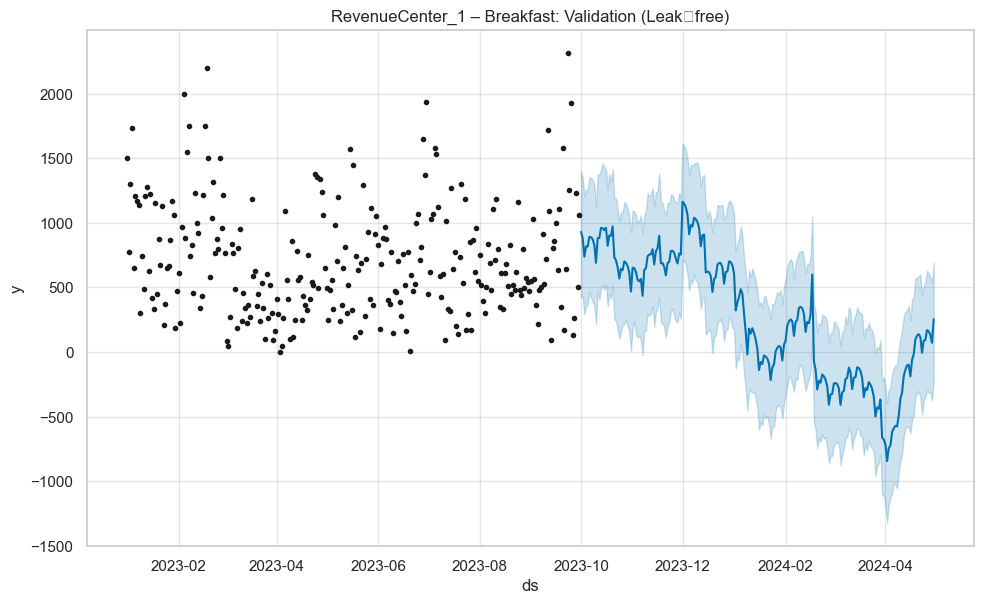

18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s


Dinner Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 688 - 10052
  Predicted range: -4444 - 6300
  Mean actual: 3247.33
  Mean predicted: -456.82
  Std actual: 1937.84
  Std predicted: 2475.07
  Most negative prediction: -4444.34
  Prediction/Actual ratio: -0.141
  Sample comparisons (Actual vs Predicted):
    1476 vs 774 (diff: 702)
    1468 vs 911 (diff: 557)
    1213 vs 743 (diff: 470)
    1342 vs 335 (diff: 1007)
    1091 vs 892 (diff: 199)


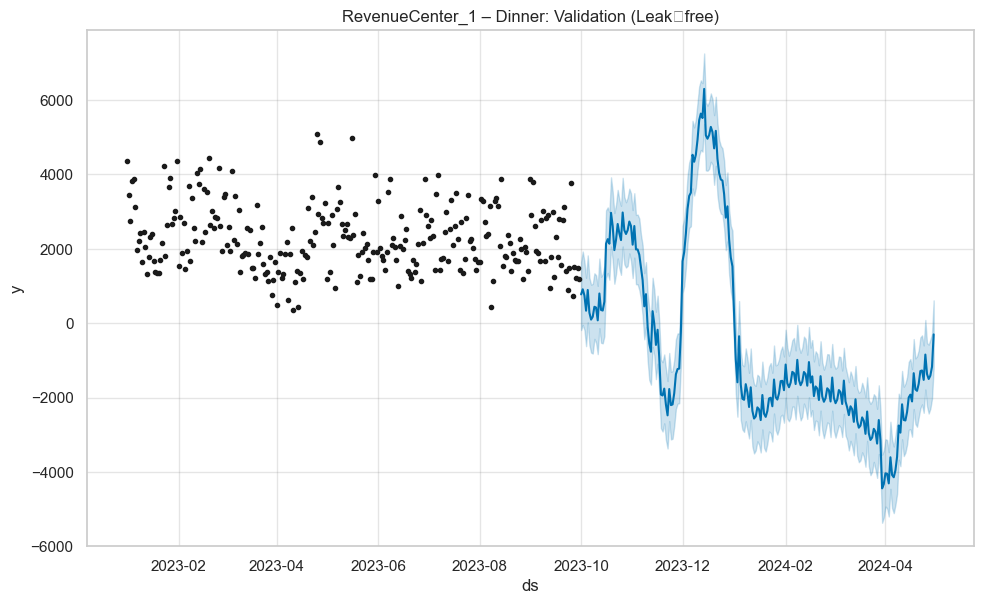

18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\pcsal\miniconda3\envs\myenv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s


Lunch Diagnostics:
  Training samples: 273
  Validation samples: 213
  Actual range: 0 - 4504
  Predicted range: 332 - 2057
  Mean actual: 913.20
  Mean predicted: 1071.81
  Std actual: 858.19
  Std predicted: 395.42
  Prediction/Actual ratio: 1.174
  Sample comparisons (Actual vs Predicted):
    142 vs 784 (diff: 642)
    118 vs 834 (diff: 716)
    220 vs 843 (diff: 623)
    613 vs 879 (diff: 266)
    180 vs 877 (diff: 697)


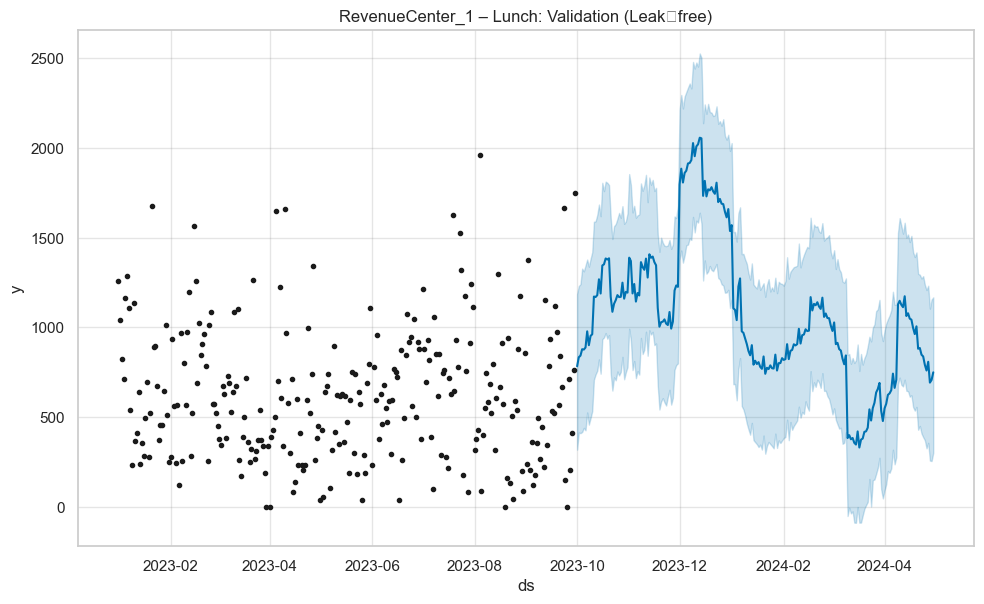


Validation (last 3 months, leak‐free):
        Meal      MAE     RMSE  MAPE_%  SMAPE_%  Acc_SMAPE_%  Acc_Relative_%  \
0  Breakfast  1212.08  1726.42  132.73   130.23         0.00               0   
1     Dinner  4342.43  5094.44  153.15   155.51         0.00               0   
2      Lunch   778.10   994.73  228.96    78.86        21.14               0   

      R²  Acc_R²_%  
0 -1.046   -104.62  
1 -5.911   -591.13  
2 -0.343    -34.35  

Model Performance Summary:
All models show poor performance (high MAPE, negative R²)

DEBUGGING STEPS TO TRY:
1. Check data scaling - are your revenue values in thousands/millions?
2. Verify date format - Prophet expects 'YYYY-MM-DD' format
3. Check for data leakage - ensure validation period is truly future
4. Examine the plots - do predictions follow actual trends at all?
5. Try simpler model first - remove all regressors and holidays
6. Check training data quality - any outliers or missing periods?

QUICK FIX TO TRY:
# Try this minimal Prophet m

In [27]:
MEALS = sorted(raw["MealPeriod"].unique())
results = []

for meal in MEALS:
    dfm = raw[raw["MealPeriod"] == meal].copy()
    dfm.rename(columns={"Date": "ds", "CheckTotal": "y"}, inplace=True)
    dfm.sort_values("ds", inplace=True)
    
    # Holiday DataFrame (Ramadan & Eid)
    hol_rows = []
    for flag, label in [("IsRamadan", "Ramadan"), ("IsEid", "Eid")]:
        if flag in dfm.columns:
            hol_rows.append(pd.DataFrame({"holiday": label, "ds": dfm.loc[dfm[flag]==1, "ds"]}))
    holidays = pd.concat(hol_rows, ignore_index=True) if hol_rows else pd.DataFrame()
    
    m = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True)
    
    regressors = [c for c in dfm.columns if c.startswith("Is") and c != "IslamicPeriod"] + ["TourismIntensity", "RevenueImpact"]
    regressors = list(dict.fromkeys(regressors))
    for r in regressors:
        if r in dfm.columns:  # Safety check
            m.add_regressor(r)
    
    # --- Train / Validation split ---
    train = dfm[dfm["ds"] < VALID_START]
    valid = dfm[dfm["ds"] >= VALID_START]
    
    # Check if we have enough training data
    if len(train) < 30:
        print(f"Warning: Only {len(train)} training samples for {meal}")
        continue
    
    m.fit(train[["ds", "y"] + [r for r in regressors if r in dfm.columns]])
    
    future_valid = valid[["ds"]].copy()
    for r in regressors:
        if r in dfm.columns:
            future_valid[r] = valid[r]
    
    forecast_v = m.predict(future_valid)
    
    # Metrics
    actual = valid["y"].values
    predicted = forecast_v["yhat"].values
    
    mae = mean_absolute_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=False)
    
    # MAPE calculation with better handling
    nonzero_mask = actual != 0
    if np.sum(nonzero_mask) > 0:
        mape = np.mean(np.abs((actual[nonzero_mask] - predicted[nonzero_mask]) / actual[nonzero_mask])) * 100
        # Cap MAPE at reasonable maximum for display
        mape = min(mape, 999.99)
    else:
        mape = np.nan
    
    r2 = r2_score(actual, predicted)
    
    # CORRECTED Accuracy calculation
    # Option 1: Symmetric MAPE-based accuracy (bounded 0-100%)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
    accuracy_smape = max(0, 100 - smape)
    
    # Option 2: Alternative accuracy based on relative error
    mean_actual = np.mean(actual)
    accuracy_relative = max(0, 100 - (rmse / mean_actual * 100)) if mean_actual > 0 else 0
    
    # Option 3: R²-based accuracy (can be negative, shows if worse than mean)
    accuracy_r2 = max(0, r2 * 100) if r2 > 0 else r2 * 100
    
    results.append({
        "Meal": meal,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE_%": round(mape, 2) if not np.isnan(mape) else "N/A",
        "SMAPE_%": round(smape, 2),
        "Acc_SMAPE_%": round(accuracy_smape, 2),
        "Acc_Relative_%": round(accuracy_relative, 2),
        "R²": round(r2, 3),
        "Acc_R²_%": round(accuracy_r2, 2)
    })
    
    # Enhanced Diagnostic information
    print(f"\n{meal} Diagnostics:")
    print(f"  Training samples: {len(train)}")
    print(f"  Validation samples: {len(valid)}")
    print(f"  Actual range: {actual.min():.0f} - {actual.max():.0f}")
    print(f"  Predicted range: {predicted.min():.0f} - {predicted.max():.0f}")
    print(f"  Mean actual: {np.mean(actual):.2f}")
    print(f"  Mean predicted: {np.mean(predicted):.2f}")
    print(f"  Std actual: {np.std(actual):.2f}")
    print(f"  Std predicted: {np.std(predicted):.2f}")
    
    # Check for problematic predictions
    if np.any(predicted < 0):
        negative_count = np.sum(predicted < 0)
        print(f"  WARNING: {negative_count} negative predictions!")
        print(f"  Most negative prediction: {predicted.min():.2f}")
    
    # Check prediction scale vs actual scale
    prediction_ratio = np.mean(predicted) / np.mean(actual) if np.mean(actual) > 0 else 0
    print(f"  Prediction/Actual ratio: {prediction_ratio:.3f}")
    
    if prediction_ratio < 0.1 or prediction_ratio > 10:
        print(f"  WARNING: Predictions are {prediction_ratio:.1f}x the actual values!")
    
    # Show some sample predictions vs actuals
    print(f"  Sample comparisons (Actual vs Predicted):")
    for i in range(min(5, len(actual))):
        print(f"    {actual[i]:.0f} vs {predicted[i]:.0f} (diff: {abs(actual[i]-predicted[i]):.0f})")
    
    m.plot(forecast_v)
    plt.title(f"{CENTER_NAME} – {meal}: Validation (Leak‐free)")
    plt.show()

print("\nValidation (last 3 months, leak‐free):")
df_results = pd.DataFrame(results)
print(df_results)

# Summary and debugging steps
print(f"\nModel Performance Summary:")
print(f"All models show poor performance (high MAPE, negative R²)")

print(f"\nDEBUGGING STEPS TO TRY:")
print(f"1. Check data scaling - are your revenue values in thousands/millions?")
print(f"2. Verify date format - Prophet expects 'YYYY-MM-DD' format")
print(f"3. Check for data leakage - ensure validation period is truly future")
print(f"4. Examine the plots - do predictions follow actual trends at all?")
print(f"5. Try simpler model first - remove all regressors and holidays")
print(f"6. Check training data quality - any outliers or missing periods?")

print(f"\nQUICK FIX TO TRY:")
print(f"# Try this minimal Prophet model to isolate the issue:")
print(f"# m = Prophet()")
print(f"# m.fit(train[['ds', 'y']])")
print(f"# forecast = m.predict(valid[['ds']])")

print(f"\nIf the issue persists, the problem is likely:")
print(f"- Data format/scaling issues")
print(f"- Insufficient or poor quality training data") 
print(f"- Revenue patterns too irregular for Prophet to capture")

In [ ]:
assert os.path.exists(FILE_PATH), f"CSV not found → {FILE_PATH}"
raw = pd.read_csv(FILE_PATH, parse_dates=["Date"])

# Drop low‑impact flags if present
raw.drop(columns=[c for c in LOW_IMPACT if c in raw.columns], inplace=True, errors="ignore")

# Integrity check
for col in ["Date", "MealPeriod", "CheckTotal"]:
    if col not in raw.columns:
        raise KeyError(f"Missing column: {col}")

# Cast binary flags (columns starting with "Is" **except** IslamicPeriod)
flag_cols = [c for c in raw.columns if c.startswith("Is") and c != "IslamicPeriod"]
for f in flag_cols:
    raw[f] = raw[f].fillna(0).astype(int)

# Encode categorical impact/intensity
raw["TourismIntensity"] = raw["TourismIntensity"].map(TI_MAP).fillna(1).astype(int)
raw["RevenueImpact"]   = raw["RevenueImpact"].map(RI_MAP).fillna(0).astype(int)

print("✓ Pre‑processing done →", raw.shape)
raw.head()

✓ Pre‑processing done → (1458, 26)


,Date,MealPeriod,RevenueCenterName,DayOfWeek,Month,Year,CheckTotal,is_zero,IslamicPeriod,IsRamadan,...,IsNationalDay,IsNewYear,IsMarathon,IsGITEX,IsAirshow,IsFoodFestival,IsPreEvent,IsPostEvent,TourismIntensity,RevenueImpact
0,2023-01-01,Breakfast,RevenueCenter_1,6,1,2023,1499.4,0,New-Year-Celebrations,0,...,0,1,0,0,0,0,0,0,3,1
1,2023-01-01,Dinner,RevenueCenter_1,6,1,2023,4374.5,0,New-Year-Celebrations,0,...,0,1,0,0,0,0,0,0,3,1
2,2023-01-01,Lunch,RevenueCenter_1,6,1,2023,1260.0,0,New-Year-Celebrations,0,...,0,1,0,0,0,0,0,0,3,1
3,2023-01-02,Breakfast,RevenueCenter_1,0,1,2023,771.0,0,Post-New-Year-Celebrations,0,...,0,1,0,0,0,0,0,1,1,0
4,2023-01-02,Dinner,RevenueCenter_1,0,1,2023,3460.0,0,Post-New-Year-Celebrations,0,...,0,1,0,0,0,0,0,1,1,0
